In [ ]:
# for Colab
!pip install botorch

In [1]:
import torch
import botorch
import gpytorch

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double # double == float64

# isn't this easier?
# https://github.com/pytorch/botorch/discussions/1444
torch.set_default_dtype(dtype)

# torch.set_default_device(device) # similarly

import numpy as np
import matplotlib.pyplot as plt

from predict_EI_simple import calculate_EI_GP, GaussainProcessRandomDataset
from utils import get_uniform_randint_generator, get_param_value


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [2]:
def plot_gp_posterior(ax, posterior, test_x, train_x, train_y, color, name=None):
    lower, upper = posterior.mvn.confidence_region()
    mean = posterior.mean.squeeze().cpu().numpy()
    lower = lower.squeeze().cpu().numpy()
    upper = upper.squeeze().cpu().numpy()

    train_x = train_x.squeeze().cpu().numpy()
    train_y = train_y.squeeze().cpu().numpy()
    test_x = test_x.squeeze().cpu().numpy()

    extension = '' if name is None else f' {name}'

    # Plot training points as black stars
    ax.plot(train_x, train_y, f'{color}*', label=f'Observed Data{extension}')
    # Plot posterior means as blue line
    ax.plot(test_x, mean, color, label=f'Mean{extension}')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x, lower, upper, color=color, alpha=0.5, label=f'Confidence{extension}')


/Users/aloja/opt/anaconda3/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


torch.Size([])
likelihood.noise_covar.raw_noise Parameter containing:
tensor([1.0000e-06], requires_grad=True)

mean_module.raw_constant Parameter containing:
tensor(0., requires_grad=True)

covar_module.raw_outputscale Parameter containing:
tensor(14.9892, requires_grad=True)

covar_module.base_kernel.raw_lengthscale Parameter containing:
tensor([[0.9345]], requires_grad=True)

True:   l=1.27, sigma^2=15, noise=0
Fitted: l=1.18, sigma^2=15, noise=0


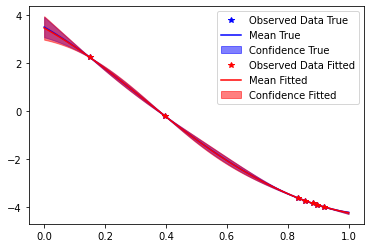

In [11]:
# randint_gen = get_uniform_randint_generator(4, 20)
# dataset = GaussainProcessRandomDataset(
#     dimension=1, n_datapoints_random_gen=randint_gen, observation_noise=False,
#     device=device)

torch.manual_seed(1703)

OBSERVATION_NOISE = False

dataset = GaussainProcessRandomDataset(
    dimension=1, n_datapoints=7, observation_noise=OBSERVATION_NOISE,
    set_random_model_train_data=True, device=device)

x_values, y_values, random_model, model = next(dataset)

print(model.batch_shape)

true_lengthscale = random_model.covar_module.base_kernel.lengthscale.squeeze().detach().numpy()
true_outputscale = random_model.covar_module.outputscale.squeeze().detach().numpy()
true_noise = random_model.likelihood.noise_covar.raw_noise.squeeze().detach().numpy()

test_x = torch.linspace(0, 1, 100, device=device)

# Get posterior under true model parameters
posterior_true = random_model.posterior(test_x, observation_noise=OBSERVATION_NOISE)


for name, param in random_model.named_parameters(): 
    print(name, param)
    print()


OPTIMIZE_RANDOM_MODEL = False # Should always be False, because random_model is broken
INIT_MODEL_PARAMS_TO_RANDOM_PARAMS = True

# Get posterior by fitting by MAP
if OPTIMIZE_RANDOM_MODEL:
    mll = ExactMarginalLogLikelihood(random_model.likelihood, random_model)
    fit_gpytorch_mll(mll)
    posterior_fitted = random_model.posterior(test_x, observation_noise=OBSERVATION_NOISE)

    fitted_model = random_model
else:
    # Set model's parameters to those of random_model
    if INIT_MODEL_PARAMS_TO_RANDOM_PARAMS:
        random_model_params_dict = {name: get_param_value(random_model, name)
                                    for name, param in model.named_parameters()}
        model.initialize(**random_model_params_dict)
    
    # set train data of model to that of random_model
    model.set_train_data(
        x_values, y_values.squeeze(-1), strict=False)
    
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    posterior_fitted = model.posterior(test_x, observation_noise=OBSERVATION_NOISE)

    fitted_model = model

fitted_lengthscale = fitted_model.covar_module.base_kernel.lengthscale.squeeze().detach().numpy()
fitted_outputscale = fitted_model.covar_module.outputscale.squeeze().detach().numpy()
fitted_noise = fitted_model.likelihood.noise_covar.raw_noise.squeeze().detach().numpy()


with torch.no_grad():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    description_true   = f'True:   l={  true_lengthscale:.3g}, sigma^2={  true_outputscale:.3g}, noise={true_noise:.3g}'
    description_fitted = f'Fitted: l={fitted_lengthscale:.3g}, sigma^2={fitted_outputscale:.3g}, noise={fitted_noise:.3g}'
    print(description_true)
    print(description_fitted)
    
    plot_gp_posterior(ax, posterior_true, test_x, x_values, y_values, 'b', name='True')
    plot_gp_posterior(ax, posterior_fitted, test_x, x_values, y_values, 'r', name='Fitted')

    ax.legend()

tensor([2.0269e-03, 1.9270e-04, 7.5164e-05, 3.4433e-01, 1.9786e-02, 2.2225e-02,
        4.4242e-07, 1.5562e-02, 8.8015e-03, 6.1681e-07, 7.2211e-03, 2.0038e-02,
        9.2556e-02, 6.4290e-02, 1.9109e-02, 9.4428e-03, 1.6219e-06, 3.3357e-02,
        6.8484e-02, 9.4962e-03, 7.7967e-03, 4.6930e-04, 6.7976e-02, 2.8472e-02,
        1.2895e-01, 2.3686e-02, 8.0571e-02, 6.4011e-02, 1.1619e-03, 1.2849e-03,
        1.0180e-03, 5.6231e-03, 9.8721e-02, 1.2166e-01, 4.4149e-02, 1.3105e-03,
        2.6654e-02, 3.7074e-01, 1.5581e-01, 2.1158e-18, 2.7185e-01, 2.8718e-01,
        6.7607e-03, 4.2195e-03, 1.3553e-04, 1.5331e-04, 8.0090e-02, 2.9139e-03,
        1.5005e-01, 1.7836e-01, 1.3513e-18, 6.5035e-12, 2.5632e-05, 7.8542e-05,
        6.4291e-05, 5.7281e-03, 1.1568e-02, 9.1476e-05, 8.5880e-06, 1.4834e-01,
        8.2763e-03, 2.4345e-02, 4.6581e-03, 3.5202e-02, 1.1973e-01, 2.3291e-03,
        1.6789e-02, 3.7009e-04, 8.0165e-04, 1.5595e-03, 2.2379e-01, 8.5130e-03,
        2.9485e-06, 1.5190e-01, 6.7812e-

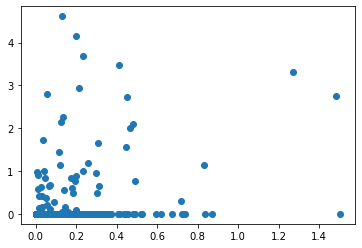

In [8]:
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()


OBSERVATION_NOISE = False
dataset = GaussainProcessRandomDataset(
    dimension=5, n_datapoints=20, observation_noise=OBSERVATION_NOISE,
    set_random_model_train_data=False, device=device)

n_samples = 1000

ei_values = torch.empty(n_samples, device=device)
improvement_values = torch.empty(n_samples, device=device)

with torch.no_grad():
    for i in range(n_samples):
        x_values, y_values, random_model, model = next(dataset)

        # x_values is shape (n_datapoints, dimension)
        # y_values is shape (n_datapoints,)
        x_hist = x_values[:-1, :]
        y_hist = y_values[:-1]
        x = x_values[-1:, :]
        y = y_values[-1:]
        ei_value, improvement_value = calculate_EI_GP(random_model, x_hist, y_hist, x, y, fit_params=False)
        ei_values[i] = ei_value[0]
        improvement_values[i] = improvement_value[0]

    print(ei_values)
    print(improvement_values)


# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

plt.scatter(ei_values.cpu().numpy(), improvement_values.cpu().numpy())